# Load libraries and functions

In [1]:
rootf = './'

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
#---------------------------------
# # For clustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import scipy as sc
# #---------------------------------
import sys
sys.path.append('./functions') 
from save_load import *
from functions_NO_MEA import*

Populating the interactive namespace from numpy and matplotlib


# Load data

In [3]:
from scipy.io import loadmat
import csv
Folder = rootf + '/data/TYPING_Baden/'
#-----------------------
# Baden data
baden = loadmat(Folder + 'baden_data.mat')
# #------------------------
chirp_stim = baden['chirp_stim'][:,0]/max(baden['chirp_stim'][:,0])
chirp_stim_time = baden['chirp_stim_time'][0,:] + 2   # 2 seconds later than my stim
baden_time_original = baden['chirp_time'][0,:]   # 2 seconds later than my stim
group_idx = baden['group_idx'] 
psth_euler = baden['chirp_avg']
#-------------------
euler_labels_f = open(Folder + 'Baden Types');
euler_labels_f = csv.reader(euler_labels_f,delimiter=",");
euler_labels={}
c=0
for row in euler_labels_f:
    if c==0:
        stim_cond_head = row
        c=1
    else:
        euler_labels[c-1]= row
        c+=1
#-------------------        

In [4]:
for i in euler_labels:
    print(euler_labels[i][0],i)
    

OFF local OS 0
OFF DS 1
OFF step 2
OFF slow 3
OFF alpha sustained 4
ON-OFF JAM-B 5
OFF sustained 6
OFF alpha transient 7
OFF mini alpha transient 8
ON-OFF local-edge W3 9
ON-OFF local 10
ON-OFF DS 1 11
ON-OFF DS 2 12
ON-OFF local OS 13
ON step 14
ON DS transient 15
ON local transient OS 16
ON transient 17
ON transient large 18
ON high frequency 19
ON low frequency 20
ON sustained 21
ON mini alpha 22
ON alpha 23
ON DS sustained 1 24
ON DS sustained 2 25
ON slow 26
ON constrast suppression 27
ON DS sustained 3 28
ON local sustained OS 29
OFF suppression 1 30
OFF suppression 2 31


### Chirps

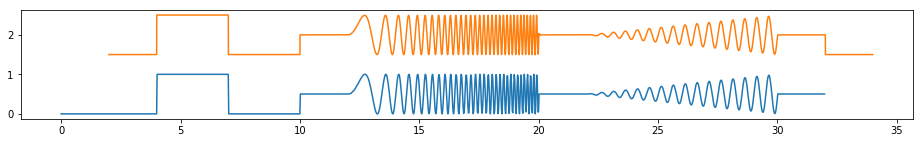

In [5]:
# Get Euler stim profile
def get_euler():
    vec_path = rootf + '/data/'
    vec_path = vec_path + r"chirp.vec"
    euler_vec = np.genfromtxt(vec_path)

    return (euler_vec[150:1750,1]/max(euler_vec[150:1750,1])) #return in 100ms steps

euler_vec= get_euler()

figure(figsize=(16,2))
time_stim = np.linspace(0,32,50*32+1)[:-1]
time = np.linspace(0,32,321)[:-1]
plot(time_stim,euler_vec)
euler_vec.shape
euler_vec[::5].shape,time.shape
# ylim([0,1])
plot(chirp_stim_time ,chirp_stim+1.5)
chirp_stim_time.shape, chirp_stim.shape

# comparison range:
comp_range = [0.1,31.9]         # to avoid prestep effects
delta_range = comp_range[1]-comp_range[0]
time_common = np.linspace(comp_range[0],comp_range[1],int(delta_range/0.05) +2)

### Euler calcium data

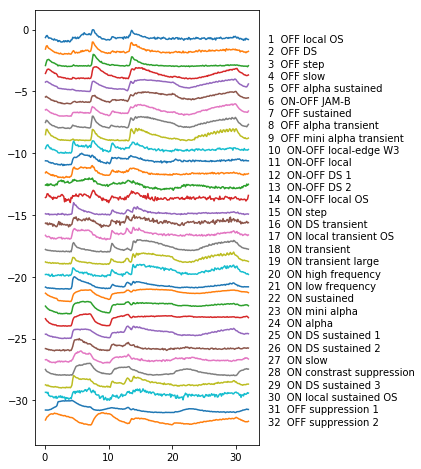

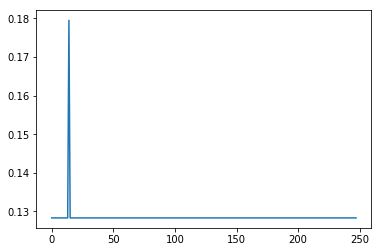

In [6]:
# Generate Baden type traces
baden_time = baden_time_original+2
baden_first = baden_time[-15:]-32
baden_time=np.append(baden_first,baden_time[:-15])


Baden_types = []
figure(figsize=(4,8))
for i in np.arange(32)+1:
    trace = np.mean(psth_euler[:,(group_idx==i)[:,0]],1)
    trace = trace-min(trace)
    trace = trace/max(trace)
    trace = np.append(trace[-15:],trace[:-15])                # I stitch last 2 s in the beggining so that it is 
                                                              #  the same as my experimental stim
    Baden_types.append(trace)
    plot(baden_time,trace-i)
    text(35,-i,str(i)+'  '+euler_labels[i-1][0])

figure()
plot(diff(baden_time))

### Experiment to calcium data

In [7]:
# experiment data
exp=8

Fsave = rootf + '/data/MEA_Data/pckls_ID/'
fsave = Fsave + 'exp'+str(exp) + '_clustermodel'
model, psth_z = load_obj(fsave)

labels = model.labels_
exp_labels = np.sort(np.unique(labels))
psth_z.shape, 'Ncells  - Ndatapoints'

((106, 320), 'Ncells  - Ndatapoints')

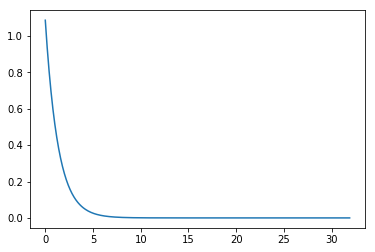

In [8]:
# functions for calcium traces
def calcium_exp(x):
    a =           0
    b =       1.086 
    c =       1.747 -1.0              
    val = a+b*np.exp(-c*x)
    return val

def toCalciumLinear(time_sequence, spike_train):
    calcium_filter = calcium_exp(time_sequence);
    
    stitch3 = np.append(spike_train,[spike_train,spike_train])
    
    calcium_trace = np.convolve(stitch3, calcium_filter, 'full')[len(spike_train):len(spike_train)*2];
    calcium_trace = calcium_trace-min(calcium_trace)
    calcium_trace=calcium_trace/max(calcium_trace)
    return calcium_trace
    

calcium_filter = calcium_exp(time);
plot(time,calcium_filter)

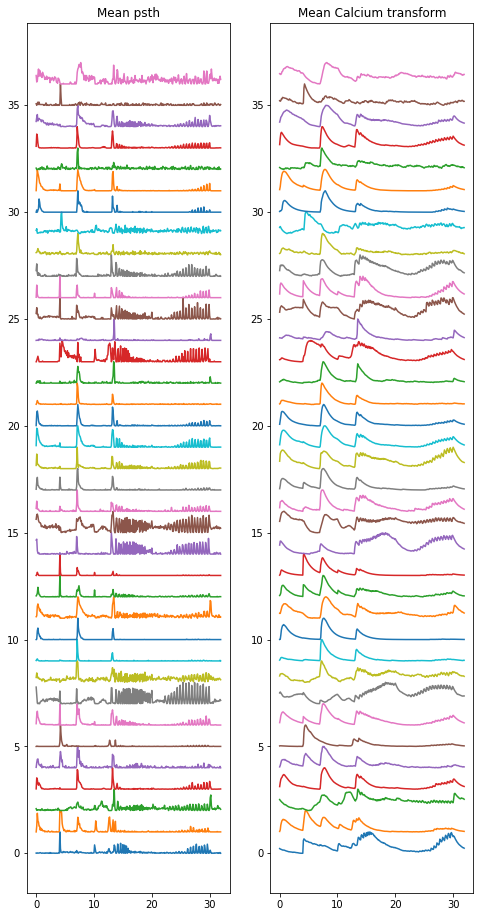

In [9]:
# Generate experiment type traces
Exp_types = []
fig = figure(figsize=(8,16))
fig.add_subplot(1,2,1)
for i in exp_labels:
    trace = np.mean(psth_z[(labels==i),:],0)
    trace = trace-min(trace)
    trace = trace/max(trace)
    Exp_types.append(trace)
    plot(time,trace+i)
    title('Mean psth')

# Experiment to calcium
Exp_types_Ca = {}
fig.add_subplot(1,2,2)
for i in exp_labels:
    trace = toCalciumLinear(time,Exp_types[i])
    Exp_types_Ca[i] = trace
    plot(time,trace+i)
    title('Mean Calcium transform')

# Correlate groups

In [10]:
# first use the same range to compare
from scipy import interpolate

Baden_common={}
for i in np.arange(32):
    f = interpolate.interp1d(baden_time,Baden_types[i])
    Baden_common[i] = f(time_common)   # use interpolation function returned by `interp1d`

    Exp_common={}
for i in exp_labels:
    f = interpolate.interp1d(time,Exp_types_Ca[i])
    Exp_common[i] = f(time_common)   # use interpolation function returned by `interp1d`


n_matches = 29
corr_table = np.zeros([len(exp_labels),32])
corr_match = np.zeros([len(exp_labels),29])
corr_match_vals = np.zeros([len(exp_labels),29])

for i in exp_labels:
    for j in np.arange(32):
        corr_table[i,j] = np.corrcoef(Exp_common[i],Baden_common[j])[0,1]
    corr_match[i,:] = np.flip(np.argsort(corr_table[i,:])[-29:])
    corr_match_vals[i,:] = corr_table[i,:][np.flip([np.argsort(corr_table[i,:])[-29:]])]

#------------------
#treat group 32 overpopulated in exp 7
if exp==7:
    for i in exp_labels:
        if corr_match[i,0]==31: 
            corr_match[i,0]=corr_match[i,2]
            corr_match[i,2]=31 
#-------------------    


# Manual selection of Groups

In [11]:
Fsave = rootf + '/data/MEA_Data/pckls_ID/'
fsave = Fsave + 'exp'+str(exp) + '_celldataID'
cell_data = load_obj(fsave)

fsave = Fsave + 'exp'+str(exp) + '_selected_cells'
selected_cells = np.array(load_obj(fsave))

match 7   11 Baden  0
match 3   11 Baden  1
match 0   11 Baden  2
match 1   11 Baden  3
match 6   11 Baden  4
match 12   11 Baden  5
match 11   11 Baden  6
match 9   11 Baden  7
match 4   11 Baden  8
match 8   11 Baden  9
match 14   11 Baden  11
match 10   11 Baden  12
match 5   11 Baden  13
match 13   11 Baden  30
match 2   11 Baden  31


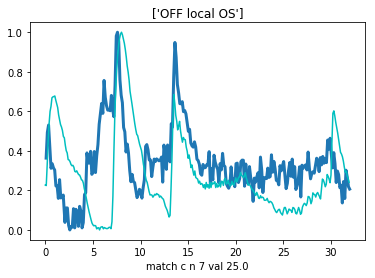

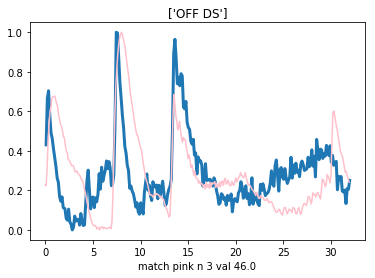

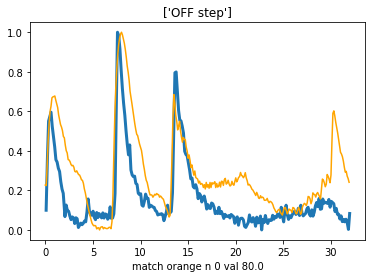

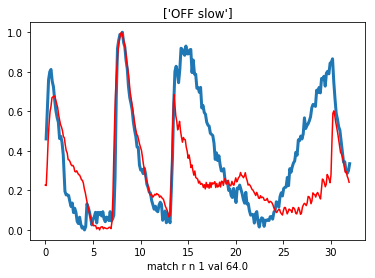

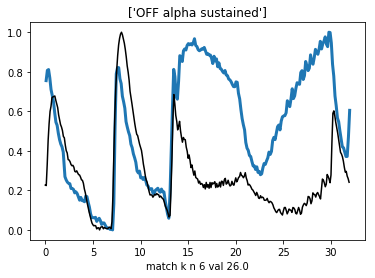

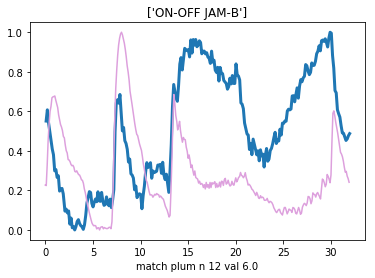

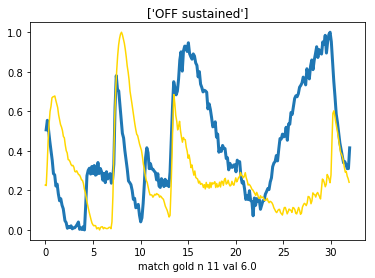

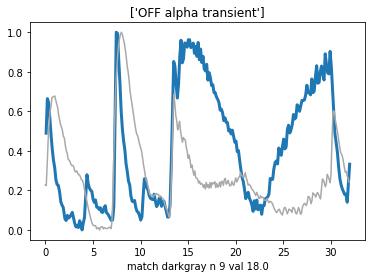

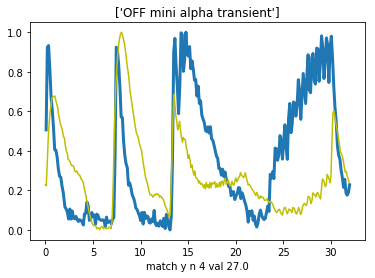

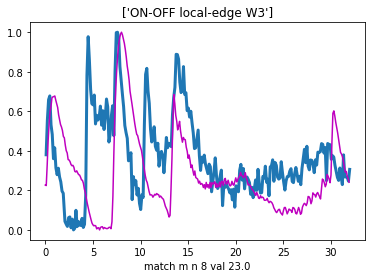

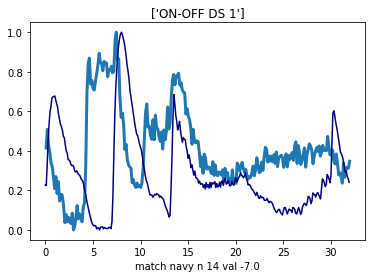

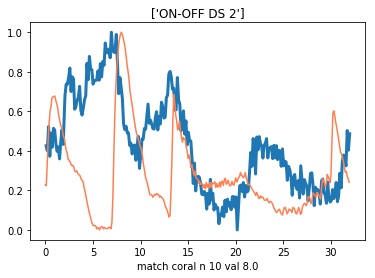

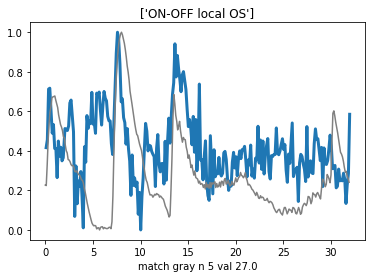

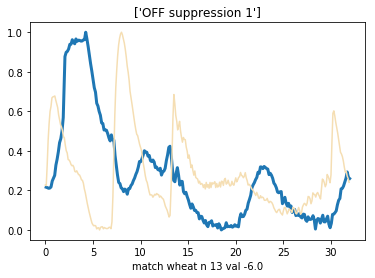

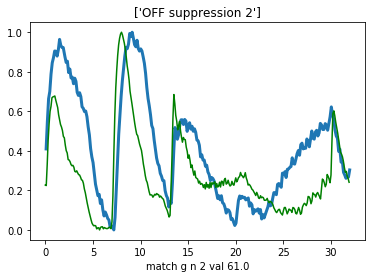

In [21]:
sel_badens = np.arange(32)
sel_cells = exp_labels

sel_cells = [11]   # select cluster group
n_match_sel = 15   # number of matches to display


colors = ['orange','r','g','pink','y','gray','k','c','m','darkgray','coral','gold','plum','wheat','navy','gold','plum','wheat','navy']
#             0     1   2    3     4    5     6   7   8      9         10      11     12      13     14
for i in sel_badens:
    Plot=False
    for j in sel_cells:
        for n_match in np.arange(n_match_sel):
            if corr_match[j,n_match]==i:
                if not(Plot): 
                    figure()
                    plot(baden_time, Baden_types[i],lw=3)
                    title(euler_labels[i])
                    Plot=True
                if Plot:
                    plot(time, Exp_types_Ca[j],color=colors[n_match%15])
                    xlabel('match '+colors[n_match%15]+' n ' +str(n_match)+' val '+str(np.round(corr_match_vals[j,n_match]*100)) )
                    print('match',str(n_match),' ',j, 'Baden ',i)
#----------------------------------------------------
manual_selection = corr_match[:,0].astype('int')

#---------------------------------------------------
#Manual matching of corrleation groups for experiments
if exp==4:
    manual_selection[0] = corr_match[0,4]
    manual_selection[5] = corr_match[5,9]
    manual_selection[6] = corr_match[6,1]
    manual_selection[9] = corr_match[9,5]
    manual_selection[10] = corr_match[10,4]
    manual_selection[11] = corr_match[11,5]
    manual_selection[12] = corr_match[12,1]
    manual_selection[13] = corr_match[13,3]
    manual_selection[14] = corr_match[14,16]
    manual_selection[19] = corr_match[19,1]
    manual_selection[20] = corr_match[20,4]
    manual_selection[21] = corr_match[21,2]
    manual_selection[27] = corr_match[27,9]
    manual_selection[29] = corr_match[29,2]
    manual_selection[31] = corr_match[31,1]
    manual_selection[34] = corr_match[34,9]  
    
if exp==5:
    manual_selection[5] = corr_match[5,4]
    manual_selection[10] = corr_match[10,1]
    manual_selection[11] = corr_match[11,3]  
    
if exp==7:
    manual_selection[1] = corr_match[1,6]
    manual_selection[2] = corr_match[2,4]
    manual_selection[3] = corr_match[3,2]
    manual_selection[5] = corr_match[5,4]
    manual_selection[7] = corr_match[7,2]
    manual_selection[9] = corr_match[9,1]
    manual_selection[12] = corr_match[12,2]
    manual_selection[15] = corr_match[15,2]
    manual_selection[16] = corr_match[16,13]
    manual_selection[19] = corr_match[19,10]
    manual_selection[21] = corr_match[21,1]
    manual_selection[22] = corr_match[22,1]
    manual_selection[25] = corr_match[25,2]
    manual_selection[28] = corr_match[28,2]
    manual_selection[30] = corr_match[30,1]
    manual_selection[37] = corr_match[37,3]
    manual_selection[39] = corr_match[39,12]
    manual_selection[40] = corr_match[40,3]
    manual_selection[41] = corr_match[41,12]
    manual_selection[42] = corr_match[42,6]
    manual_selection[43] = corr_match[43,24]

    for j in [  36 ,28]:#
        manual_selection[j] = -1# not good clusters
    
if exp==8:
    manual_selection[2] = corr_match[2,12]
    manual_selection[3] = corr_match[3,1]
    manual_selection[4] = corr_match[4,18]
    manual_selection[6] = corr_match[6,8]
    manual_selection[7] = corr_match[7,1]
    manual_selection[9] = corr_match[9,1]
    manual_selection[11] = corr_match[11,1]
    manual_selection[12] = corr_match[12,1]
    manual_selection[16] = corr_match[16,2]
    manual_selection[19] = corr_match[19,2]
    manual_selection[20] = corr_match[20,2]
    manual_selection[22] = corr_match[22,1]
    manual_selection[24] = corr_match[24,2]
    manual_selection[25] = corr_match[25,9]
    manual_selection[26] = corr_match[26,3]
    manual_selection[28] = corr_match[28,3]
    manual_selection[31] = corr_match[31,1]
    manual_selection[33] = corr_match[33,3]
#     for j in [25]:#
#         manual_selection[j] = -1 #bad cluster

In [22]:
#----------------------------------------
man_vals= np.zeros(len(exp_labels))
for i in exp_labels:
    if manual_selection[i]!=-1:
        match = np.where(manual_selection[i]==corr_match[i,:])[0][0]
        man_vals[i] = corr_match_vals[i,match]

# Plot the preclusters in the final Groups

Group 9    Baden  0 ['OFF local OS']
Group 28    Baden  0 ['OFF local OS']
Group 32    Baden  0 ['OFF local OS']
Group 22    Baden  1 ['OFF DS']
Group 24    Baden  1 ['OFF DS']
Group 3    Baden  3 ['OFF slow']
Group 11    Baden  3 ['OFF slow']
Group 18    Baden  3 ['OFF slow']
Group 20    Baden  3 ['OFF slow']
Group 7    Baden  4 ['OFF alpha sustained']
Group 15    Baden  4 ['OFF alpha sustained']
Group 8    Baden  5 ['ON-OFF JAM-B']
Group 14    Baden  5 ['ON-OFF JAM-B']
Group 4    Baden  7 ['OFF alpha transient']
Group 6    Baden  7 ['OFF alpha transient']
Group 27    Baden  7 ['OFF alpha transient']
Group 16    Baden  8 ['OFF mini alpha transient']
Group 26    Baden  8 ['OFF mini alpha transient']
Group 33    Baden  8 ['OFF mini alpha transient']
Group 1    Baden  9 ['ON-OFF local-edge W3']
Group 12    Baden  9 ['ON-OFF local-edge W3']
Group 13    Baden  9 ['ON-OFF local-edge W3']
Group 2    Baden  10 ['ON-OFF local']
Group 5    Baden  20 ['ON low frequency']
Group 29    Baden  20 ['

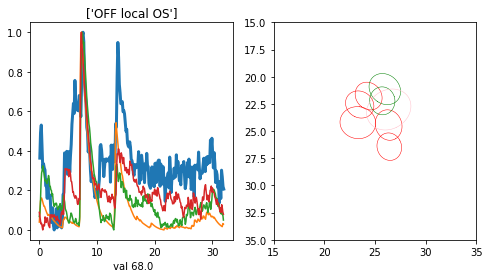

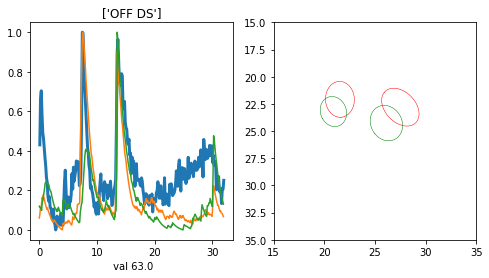

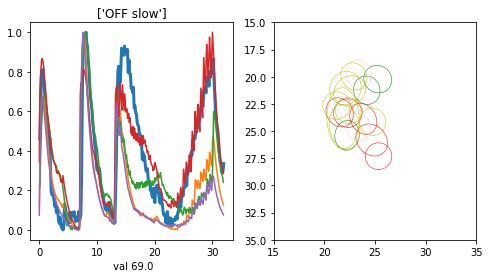

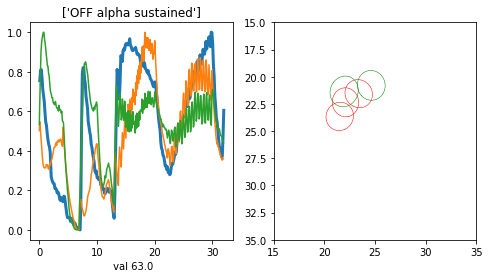

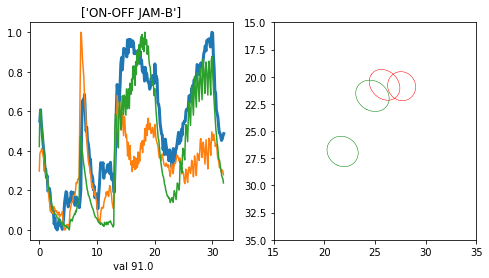

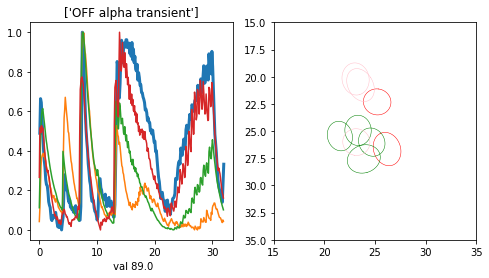

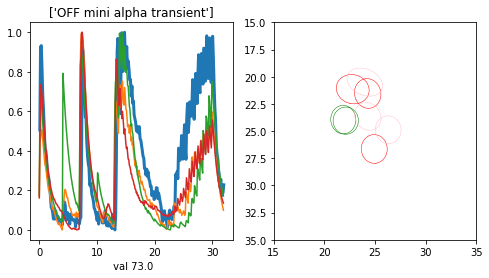

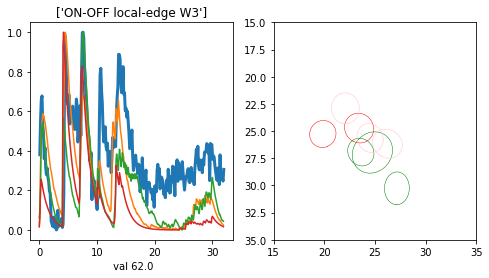

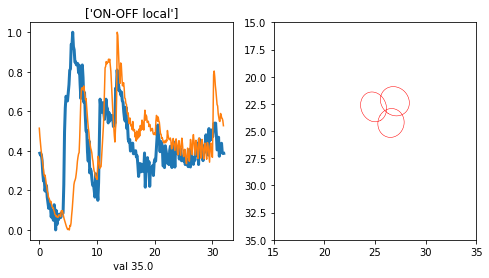

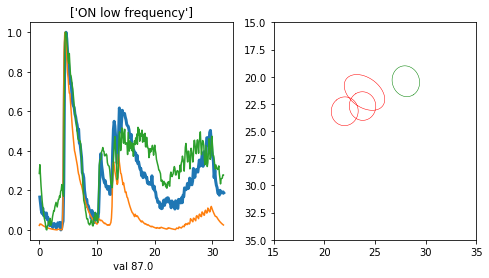

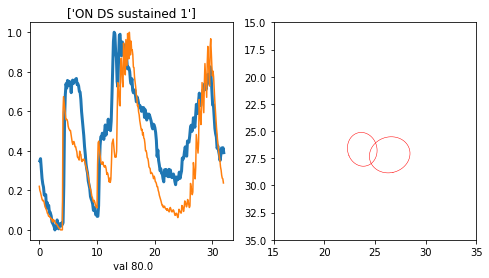

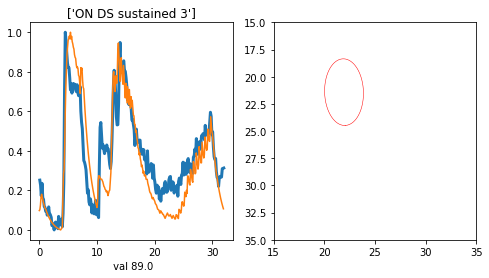

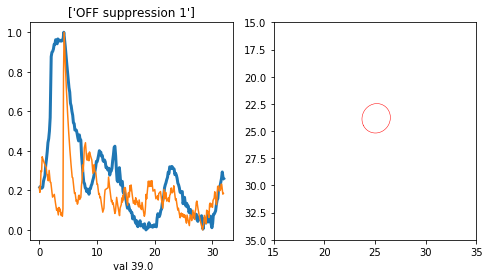

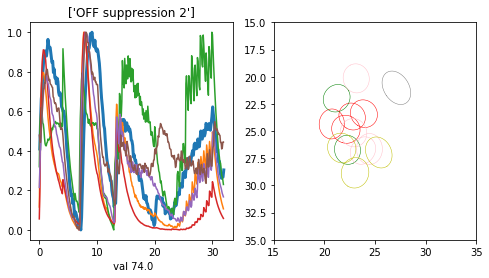

In [23]:
# Here plot the final groups
sel_badens = np.arange(32)
sel_exps = exp_labels

# sel_badens = [22]
Nclus = [0,0,0,0,36,12,0,44,37]
sel_cells = np.arange(Nclus[exp])      #############PUT NUMBER OF SUBCLUSTERS HERE! exp4=36 - exp5=12 - exp7=44 - exp8=37

# done_skip = list(set(np.arange(32))-set([2]))
done_skip = [2]#[2,3,4,5,7,8,9,17,19,20,21,23,24,26,27,31] #skip some plots
countg=0
for i in list(set(sel_badens)-set(done_skip)):
    cc=0
    Plot=False
    for j in sel_cells:
        if manual_selection[j]==i:
            if not(Plot): 
                fig=figure(figsize=(8,4))
                ax1 = fig.add_subplot(1,2,1)
                ax2 = fig.add_subplot(1,2,2)
                ax1.plot(baden_time, Baden_types[i],lw=3)
                ax1.set_title(euler_labels[i])
                Plot=True
                countg+=1
            if Plot:
                
                ax1.plot(time, Exp_types_Ca[j])
                ax1.set_xlabel(' val '+str(np.round(man_vals[j]*100)) )#+ euler_labels[i][1])
                
                clustersin = selected_cells[np.where((model.labels_==j))[0]]
                cc+=1
                for neuron in clustersin:
                    c=list(selected_cells).index(neuron) 
                    ax2.plot(cell_data[c]['ellipseMat_c1'][0]   , cell_data[c]['ellipseMat_c1'][1] ,color=colors[cc] ,lw=0.5)#,lw=10)    #rotated ellipse
                ax2.set_xlim(15,35)
                ax2.set_ylim(35,15)
                print('Group',j, '   Baden ',i, euler_labels[i])
print('counts' ,countg)

### New cluster labels

In [24]:
new_labels = np.zeros(len(model.labels_))
for j in np.arange(len(model.labels_)):
    new_labels[j] = manual_selection[model.labels_[j]]
    #########################################
    # change individual cells from subclusters badly assigned
    cell_nb = list(selected_cells)[j]
    
    if exp==4:
        if cell_nb in [3]:
            new_labels[j]=1
        if cell_nb in [720,1010,1099]:
            new_labels[j]=19
        if cell_nb in [490]:
            new_labels[j]=20
        if cell_nb in [128]:
            new_labels[j]=21
        if cell_nb in [ 1096]:
            new_labels[j]=22
        if cell_nb in [1098 ] :
            new_labels[j]=23
        if cell_nb in [1187, 1257]:
            new_labels[j]=24
        if cell_nb in [1391]:
            new_labels[j]=30   
        if cell_nb in [206,580,995,367,1020,894,999,998]:
            new_labels[j]=31

    if exp==5:
        if cell_nb in [1206,1187,457,1104,1381]:
            new_labels[j]=22
        if cell_nb in [1212]:
            new_labels[j]=23
            
    if exp==7:
        if cell_nb in [177,964] :
            new_labels[j]=9
        if cell_nb in [787,1322]:
            new_labels[j]=31
            
    if exp==8:
        if cell_nb in [86,215,232,584,701,921]:
            new_labels[j]=1
        if cell_nb in [251,537,110]:
            new_labels[j]=2
        if cell_nb in [739,787]:
            new_labels[j]=3
        if cell_nb in [163,893,410]:
            new_labels[j]=4
        if cell_nb in [809]:
            new_labels[j]=7
        if cell_nb in [182]:
            new_labels[j]=9
#         if cell_nb in [281]:  # correct is OFF alpha transient
#             new_labels[j]=7   # correct here for that

        if cell_nb in [921]:
            new_labels[j]=-1 # bad cell

    #####################################3
# here assign label to each cluster
Dic_labels={}
for i in np.arange(len(new_labels)):
    if new_labels[i]!=-1:
        Dic_labels.update({list(selected_cells)[i]: euler_labels[new_labels[i]]})
#--------------------
for c in sorted(list(Dic_labels.keys())):
     print('Clus ',c, '   Baden ',Dic_labels[c])

Clus  29    Baden  ['OFF alpha transient']
Clus  48    Baden  ['OFF alpha transient']
Clus  60    Baden  ['OFF slow']
Clus  64    Baden  ['OFF slow']
Clus  65    Baden  ['OFF mini alpha transient']
Clus  80    Baden  ['OFF slow']
Clus  86    Baden  ['OFF DS']
Clus  91    Baden  ['OFF slow']
Clus  110    Baden  ['OFF step']
Clus  124    Baden  ['OFF step']
Clus  126    Baden  ['OFF step']
Clus  129    Baden  ['ON DS sustained 3']
Clus  142    Baden  ['ON DS sustained 1']
Clus  151    Baden  ['OFF step']
Clus  163    Baden  ['OFF alpha sustained']
Clus  179    Baden  ['OFF slow']
Clus  182    Baden  ['ON-OFF local-edge W3']
Clus  188    Baden  ['OFF suppression 2']
Clus  192    Baden  ['OFF DS']
Clus  194    Baden  ['OFF suppression 1']
Clus  198    Baden  ['ON-OFF local-edge W3']
Clus  215    Baden  ['OFF DS']
Clus  227    Baden  ['OFF mini alpha transient']
Clus  232    Baden  ['OFF DS']
Clus  240    Baden  ['ON low frequency']
Clus  242    Baden  ['ON-OFF local']
Clus  249    Baden  [

### Generate New Type Traces

/Users/matias/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/matias/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


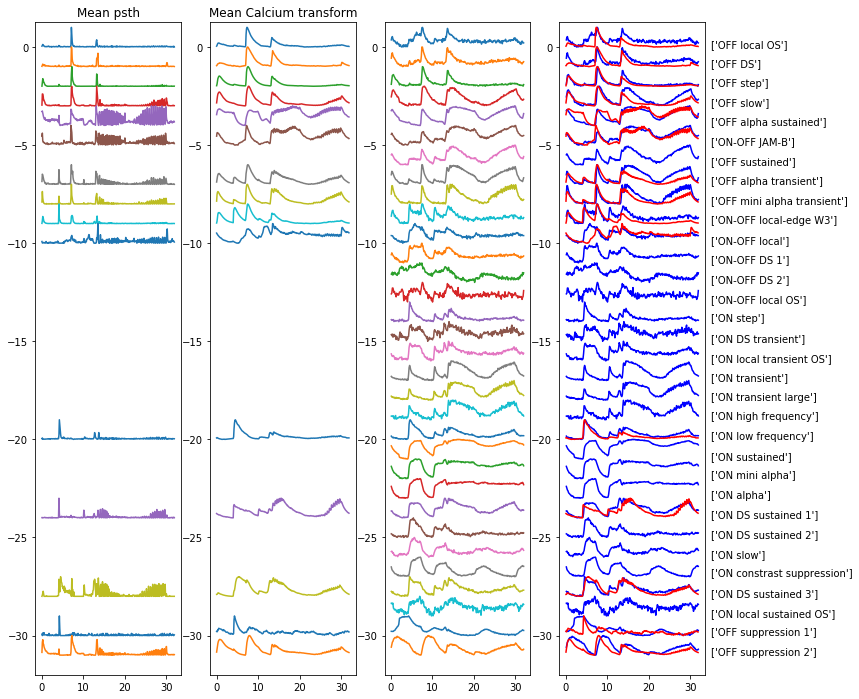

In [25]:
# Generate new experiment type traces
Exp_sorted_types = []
fig = figure(figsize=(12,12))
fig.add_subplot(1,4,1)
for i in euler_labels.keys():
    trace = np.mean(psth_z[(new_labels==i),:],0)
    trace = trace-min(trace)
    trace = trace/max(trace)
    Exp_sorted_types.append(trace)
    plot(time,trace-i)
    title('Mean psth')
    ylim([-32,1.25])
    
# Experiment to calcium
Exp_sorted_types_Ca = {}
fig.add_subplot(1,4,2)
for i in euler_labels.keys():
    trace = toCalciumLinear(time,Exp_sorted_types[i])
    Exp_sorted_types_Ca[i] = trace
    plot(time,trace-i)
    title('Mean Calcium transform')
    ylim([-32,1.25])
fig.add_subplot(1,4,3)
for i in euler_labels.keys():
        plot(baden_time,Baden_types[i]-i)
        ylim([-32,1.25])
        
fig.add_subplot(1,4,4)
for i in euler_labels.keys():
        plot(baden_time,Baden_types[i]-i,'b')
        plot(time,Exp_sorted_types_Ca[i]-i,'r')
        text(35,-i,euler_labels[i])
        ylim([-32,1.25])

# Create a summary figure for each cluster type

In [26]:
#-------------------------------------------------------
from matplotlib import gridspec

# for icluster in range(len(euler_labels))[0:]: # use this line to plot all
for icluster in [31]: 
    idx_cluster = np.where(new_labels==icluster)[0]
    print(len(idx_cluster))

    gs = gridspec.GridSpec(len(idx_cluster)+3,6)
    
    if len(idx_cluster)<7:
        yspan = 2
    else:
        yspan=-2
    fig=figure(figsize=(14,(len(idx_cluster)+yspan)*1.75))
    plt.suptitle("Cell group {}   {}   {} cells.".format(icluster,euler_labels[icluster], len(idx_cluster)),size=24)

    #-------------------------------
    # Loop cells in cluster
    line = 2
    STAs=np.zeros(40)
    STAcount=0
    waves=np.zeros(101)
    wavecount=0
    for index in sorted(idx_cluster):
        cell_nb = index
        
        #-----------------
        # Plot temp STA
        ax= subplot(gs[line+1,1])
        
        ax.set_ylim([-0.85,0.85])
        ax.axis("off")
#         ax.set_aspect(0.075)
        ax.step(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta_c1"],'k',lw=3)
        polarity = cell_data[cell_nb]["polarity_c1"]
        ax.set_title('Cluster ' + str(selected_cells[cell_nb]) + '    preclus '+str(model.labels_[cell_nb]))
        ax.axhline(0,color='k',lw=0.5)
        
        STAs+=cell_data[cell_nb]["temporal_sta_c1"]
        STAcount+=1
        
        #-----------------
        # Plot temp STA avg
        ax= subplot(gs[0,1])
        
        ax.set_title('Temp STA')
        ax.set_ylim([-0.85,0.85])
        ax.plot(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta_c1"],lw=0.5)
        ax.axhline(0,color='k',lw=0.5)
        ax.set_xlabel('Time(s)')
        
        #-----------------
        # plot Spatial STA
        ax= subplot(gs[line+1,0])
                
        ax.imshow(cell_data[cell_nb]["spatial_sta_c1"], cmap='gray',interpolation='gaussian')
        ax.set_xlim(15,35)
        ax.set_ylim(35,15)
        ax.set_aspect('equal')
        #ax.set_title('Cluster' + str(cell_nb))
        ax.set_xticks([])
        ax.set_yticks([])
       
        #----------------
        #plot waveform
        ax= subplot(gs[line+1,2])
        
        wave = cell_data[cell_nb]["templates"]/abs(np.min(cell_data[cell_nb]["templates"]))
        ax.plot(wave,'r')
        ax.axis("off")
        ax.set_ylim([-1.25,1.25])
        waves+=wave
        wavecount+=1
        
        ax= subplot(gs[0,2])
        ax.plot(wave,lw=0.5)
        ax.axis("off")
        ax.set_ylim([-1.25,1.25])
        #-----------------
        # plot Euler
        ax= subplot(gs[line+1,3:])
        
#         cell_index=list(selected_cells).index(cell_nb)
        cell_index=cell_nb
        ax.plot(np.linspace(0,32,800),cell_data[cell_nb]["psth_c1"])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([])
        plt.locator_params(axis="y", nbins=3)
        
        ax= subplot(gs[line+1,0])
        ax.plot(cell_data[cell_nb]['ellipseMat_c1'][0]   , cell_data[cell_nb]['ellipseMat_c1'][1] ,'yellow',alpha=0.5 )#,lw=10)    #rotated ellipse
        ax= subplot(gs[0:2,0])
        ax.plot(cell_data[cell_nb]['ellipseMat_c1'][0]   , cell_data[cell_nb]['ellipseMat_c1'][1] ,'k' ,lw=0.5)#,lw=10)    #rotated ellipse
        
        line+=1
    
    #-----------------
    # avg STA
    STAs=STAs/STAcount
    ax= subplot(gs[0,1])
    ax.plot(np.linspace(-40/30,0,40),STAs,'k',lw=2)
    ax.set_ylim([-0.85,0.85])
#     ax.set_aspect(0.075)
    ax.axis("off")
    
    #-----------------
    # avg wave
    waves=waves/wavecount
    ax= subplot(gs[0,2])
    ax.set_title('Waveform')
    
    ax.plot(waves,'r',lw=2)
    ax.set_ylim([-1.25,1.25])
    #ax.set_aspect(0.075)
    ax.axis("off")
    
    #-----------------
    # size ellipses
    ax= subplot(gs[0:2,0])
    
    ax.set_title('Ellipses')
    ax.set_xlim(15,35)
    ax.set_ylim(35,15)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
        
    #-----------------
    # mean psth
    ax= subplot(gs[0,3:])
    ax.set_title('Euler psth')
    
    ax.plot(np.linspace(0,32,320),np.mean(psth_z[idx_cluster,:], 0),'b')
    ax.axis("off")
    
    #-----------------
    # mean Ca trace + comparison
    ax= subplot(gs[1,3:])
    ax.text(-9,1,'Calcium traces')
    ax.axis("off")
            
    plot(time,Exp_sorted_types_Ca[icluster] ,'b')
    plot(baden_time,Baden_types[icluster],'r')
    

    #-----------------
    # plot euler stim
    euler_vec= get_euler()
    ax= subplot(gs[2,3:])
    
    ax.plot(time_stim,euler_vec, color='k')
    ax.set_yticks([])
    ax.set_ylim([-0.25,1.25])
    ax.set_xlabel('Time(s)')
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax= subplot(gs[2,2])
    ax.text(0.5,0.5 ,"Chirp stimulus profile")
    ax.axis("off")
    
    
    new_labels[j]
    PDF_folder = rootf + '/OUTPUT_NO_MEA/Cell_type/Done/'
    fsave = PDF_folder +'exp'+str(exp)+'_clustype' +str(icluster) 
    
    fig.savefig(fsave+'.png',format='png',dpi=250)

    close(fig)    


13


/Users/matias/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


# SAVE DATA

In [28]:
Fsave = rootf + '/data/MEA_Data/pckls_ID/'
fsave = Fsave + 'exp'+str(exp) + '_celltype_baden'
save_obj(new_labels,fsave)


Fsave = rootf + '/data/MEA_Data/pckls_ID/'
fsave = Fsave + 'exp'+str(exp) + '_celltype_exp24_Ca_traces'
save_obj(Exp_sorted_types_Ca,fsave)


# Plot cell ID in corresponding folder

In [29]:
# More complicated ID card
ttext = ['native','  NO','  wo']
PLOT=False

if PLOT:
    for idx_cell in (range(len(selected_cells[0:]))):

        cell_nb = idx_cell

        if new_labels[idx_cell]==-1:continue

        # Create the figure
        fig = plt.figure(figsize=(20, 12))

        # the size of the marginal axes and the main axes in both directions.
        gs = gridspec.GridSpec(8, 8,
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.3, hspace=0.8)   
        gridspec.GridSpec
        try:
            cluster = model.labels_[idx_cell]#[0]
        except:
            cluster=''

        cell_data[cell_nb]["clus_ID"]=cluster

        plt.suptitle("exp{} _c{}  - Cluster_group_{}  {}".format(exp,selected_cells[cell_nb],cluster,euler_labels[new_labels[cell_nb]]), fontsize=20)


        # plot Spatial STA
        ax= subplot(gs[0:2,5:7])

        for cell in np.where(new_labels==new_labels[cell_nb])[0]:
            ax.plot(cell_data[cell]['ellipseMat_c1'][0]   , cell_data[cell]['ellipseMat_c1'][1] ,'k')#,lw=10)    #rotated ellipse

        ax.plot(cell_data[cell_nb]['ellipseMat_c1'][0]   , cell_data[cell_nb]['ellipseMat_c1'][1] ,'y',lw=2)#,lw=10)    #rotated ellipse
        ax.set_xlim(15,35)
        ax.set_ylim(35,15)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])


        #--------------------------------------------------
        # Plot the ISI
        ax = fig.add_subplot(gs[0:1, 3:4])
        ax.hist(cell_data[cell_nb]['isi'], bins = 100, range=(0,0.05))
        rpv = cell_data[cell_nb]['rpv']
        nb_rpv= cell_data[cell_nb]['nb_rpv_spikes']
        ax.set_title("Interspike Interval histogram\n RPV = {}%. {}/{} spikes.".format(round(rpv,4), nb_rpv, cell_data[cell_nb]["nb_spikes"]))
    #     ax.set_xlabel("Interspike time (s)")
    #     ax.set_ylabel("Number of spikes")
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.axvline(0,color='k',lw=0.5)

        #--------------------------------------------------
        # Plot the cell's template
        ax = fig.add_subplot(gs[0:1, 4:5])
        wave = cell_data[cell_nb]["templates"]/abs(np.min(cell_data[cell_nb]["templates"]))
        ax.plot(np.linspace(-2.5,2.5,101),wave,color='r',lw=2)
        ax.set_title("Cell template")
    #     ax.set_xlabel("Time (ms)")
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.axhline(0,color='k',lw=0.5)
        ax.set_ylim([-1.25,1.25])
        ax.set_yticks([])

        #--------------------------------------------------
        # Plot spatial STA
        for i in [0,1,2]:
            if i==0:spatial=cell_data[cell_nb]['spatial_sta_c1']
            if i==1:spatial=cell_data[cell_nb]['spatial_sta_no']
            if i==2:spatial=cell_data[cell_nb]['spatial_sta_wo']

            ax = fig.add_subplot(gs[2+i*2:4+i*2, 4:5])
            if i==0:ax.text(14,11.35,"Spatial receptive field",size=12)
            spatial = spatial**2*sign(spatial)
            cmap='RdBu_r'
            im = ax.imshow(spatial, cmap=cmap,interpolation='gaussian')
            # plt.colorbar(im, ax=axs[1,2])
            abs_max = 0.5*max(np.max(spatial), abs(np.min(spatial)))
            im.set_clim(-abs_max,abs_max)

            u250 = 1/42*50*2  *2.5
            ax.set_xticks(np.arange(10)*u250)
            ax.set_xticklabels(labels = np.arange(10)*250-750)
            ax.set_yticks(np.arange(10)*u250)
            ax.set_yticklabels(labels = np.arange(10)*250-750)

            ax.set_xlim([15,35])
            ax.set_ylim([35,15])
            ax.set_xlabel(r'$\mu$ m')
            ax.set_ylabel('$\mu$ m            ')

        #--------------------------------------------------
        # Plot checkerboard repeated sequence raster
        for i in [0,1,2]:
            if i==0:check=cell_data[cell_nb]['cb_spike_trains_c1']
            if i==1:check=cell_data[cell_nb]['cb_spike_trains_no']
            if i==2:check=cell_data[cell_nb]['cb_spike_trains_wo']    

            ax = fig.add_subplot(gs[2+i*2:3+i*2, 5:8])
            ax.eventplot(check, color='k', alpha=1,linelengths=1)
            if i==0:ax.set_title("Repeated white noise sequences")
    #         ax.set_xlabel("Time (s)")
            ax.set_xlim([0,20])
            ax.set_ylim([0,None])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        #--------------------------------------------------
        # Plot checkerboard repeated sequence psth (superimposed)

            ax = fig.add_subplot(gs[3+i*2:4+i*2, 5:8])

            nb_rep=len(check)
            psthch = np.histogram(np.concatenate(check).tolist(), bins=linspace(0,20,601))[0]/nb_rep*1000/30
            ax.plot(np.linspace(0,20,600), psthch)
            if i==2: ax.set_xlabel("Time (s)")
            ax.set_xlim([0,20])
        #     ax.set_ylabel("Firing rate (spikes/s)")
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            cell_data[cell_nb]["check_psth"] = psthch

        #--------------------------------------------------
        # Plot temporal STA
        for i in [0,1,2]:
            if i==0:temporal=cell_data[cell_nb]['temporal_sta_c1']
            if i==1:temporal=cell_data[cell_nb]['temporal_sta_no']
            if i==2:temporal=cell_data[cell_nb]['temporal_sta_wo']

            ax = fig.add_subplot(gs[2+i*2:4+i*2, 3:4])
            if i==0:ax.set_title("Temporal receptive field")
            ax.step(np.linspace(-40/30,0,40), temporal,color='k',lw=3)
            ax.set_xlabel("Time (s)")
            ax.axhline(0,color='k',lw=0.5)

            ax.set_yticks([])
            ax.axis('off')

        #--------------------------------------------------
        # Plot chirp psth
        for i in [0,1,2]:
            if i==0:psth=cell_data[cell_nb]['psth_c1']
            if i==1:psth=cell_data[cell_nb]['psth_no']
            if i==2:psth=cell_data[cell_nb]['psth_wo']

            ax = fig.add_subplot(gs[3+i*2:4+i*2, 0:3])

            ax.plot(np.linspace(0,32,800), psth,lw=1)
            # ax.set_ylim(-5,2*np.max(data_20210316[cell_nb]["euler_full_field"]["psth"]))
            if i==2:ax.set_xlabel("Time (s)")
            ax.set_ylabel("Firing rate (spikes/s)")
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xlim(0, 32)

        #--------------------------------------------------
         # Plot euler raster
            ax = fig.add_subplot(gs[2+i*2:3+i*2, 0:3])
            if i==0:chirp=cell_data[cell_nb]['chirp_spike_trains_c1']
            if i==1:chirp=cell_data[cell_nb]['chirp_spike_trains_no']
            if i==2:chirp=cell_data[cell_nb]['chirp_spike_trains_wo']

            ax.eventplot(chirp, color='k', alpha=1,linelengths=1,lw=1)
            ax.set_xlim(0, 32)
            ax.set_ylim(0, 20)
            # ax.set_yticks([])
            ax.set_ylabel("#Trial")
            if i==0:ax.set_title("Response to the chirp stimulus")
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)


            ax.text(-8,-5,ttext[i],size=20)


        #--------------------------------------------------
        # Plot euler stimulus profile (superimposed)
        ax = fig.add_subplot(gs[1:2, 0:3])
        ax.plot(np.linspace(0,32,1600),euler_vec, color='k',lw=0.75)
        # ax.set_ylim(-800,300)
        ax.set_yticks([])
        ax.set_title("Chirp stimulus profile")
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim(0, 32)



        PDF_folder = rootf + 'OUTPUT_NO_MEA/Cell_type/Collections/Exp'+str(exp)+'/'
        fsave = PDF_folder +'Type'+str(int(new_labels[cell_nb])+1)+'-'+euler_labels[new_labels[cell_nb]][0]+'-'+' exp'+str(exp)+'_c' +str(selected_cells[cell_nb]) + '_group' + str(cluster) + '_ID' 

        fig.savefig(fsave+'.png',format='png',dpi=110)
        close(fig)  
    print('Done!')